In [ ]:
#!/usr/bin/env python
""" Pflichtübung für Maschinelles Lernen an der HS Mannheim zu Genetische Algorithmen"""

' 3. Pflichtübung für Maschinelles Lernen an der HS Mannheim zu Genetische Algorithmen'

In [ ]:
import string
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import copy
from typing import List, Tuple

In [ ]:
__maintainer__ = "Rosario Allegro"

In [ ]:
GENES   =   10
BITS    =   100

c       =   0.0001
s       =   0.8
m       =   0.5
EPOCHS  =   50

SelectionType   = Enum("SelectionType", "WHEEL TOURNAMENT") # Für die Wahl von Kandidaten
CrossoverType   = Enum("CrossoverType", "ONEPOINT")         # Für die Wahl von der Crossover-Logik, erweiterbar zB PMX, ERX

In [ ]:
def initialize_population(genes, bits) -> Tuple[int, ...]:
  """ Zufällige Population wird erstellt mit dem Format genes x bits. """
  return np.random.randint(2, size=(genes, bits))

In [ ]:
def initialize_volumes(genes, bits) -> List[float]:
  """ Erstellen einer Liste mit zufälligen Volumen zwischen 0 und 10. """
  return np.random.rand(BITS,1)*10

In [ ]:
def fitness_sum(genes, bg, v, bits) -> float:
  """ Errechnet die Summe der einzelnen Fitness und gibt diese zurück. """
  return np.sum([fitness(hj, bg, v, bits) for hj in range(genes)])

In [ ]:
def fitness(i, bg, v, bits) -> float:
  """ Errechnet ein einzelnes Fitness nach der gegebenen Formel und gibt diese zurück. """
  value = 0
  for g in range(bits):
    value += bg[i][g]*v[g]
  return (np.exp(-c*(np.power(100-value, 2))))

In [ ]:
def calculate_probability(bg, volume, bits, genes) -> float:
  """ Errechnet eine Wahrscheinlichkeit für eine Hypothesis durch die Summe aller Hypothesen. """
  sum = fitness_sum(genes, bg, volume, bits)
  return [fitness(n, bg, volume, bits) / sum for n in range(genes)]

In [ ]:
def generate_crossover_candidates(genes, nCrossover) -> int:
  """ Erstellt eine Liste mit zufälligen Crossover-Kandidaten. """
  return random.sample(range(0, genes), nCrossover)

In [ ]:
def generate_crossoverpoint(bits, sum) -> int:
  """ Zur generierung von möglichen n-Crossoverpunkten """
  crossover_points = [random.randint(0, bits) for n in range(sum)]
  crossover_points += crossover_points[::-1]
  yield from crossover_points

In [ ]:
def generate_sequence(f_half, s_half, crossover_point, bits, bg) -> List[int]:
  """ Erstellt eine neue Sequenz aus 0er und 1er aus beiden Elternteile.
  f_half: Erster Elternteil
  s_half: zweiter Elternteil
  crossover_point: eine zufällig-ermittelter Crossover-Wert
  """
  return ([first_parent for idx, first_parent in enumerate(bg[f_half]) if idx <= crossover_point] + 
          [second_parent for idx, second_parent in enumerate(bg[s_half]) if idx < bits-crossover_point-1])

In [ ]:
def create_childrens(bg, genes, bits, crossover_candidates) -> List[int]:
  """ Erzeugt Kinder der vorgegebenen Crossover-Kandidaten. Prüft, ob die Kandidaten gerade sind, 
  andernfalls entferne den letzten Wert.
  """
  if(len(crossover_candidates)%2):
    crossover_candidates.pop()
  crossover_points = generate_crossoverpoint(bits, int(len(crossover_candidates)/2))
  crossover_candidates += crossover_candidates[::-1]
  return [ generate_sequence(crossover_candidates[index], crossover_candidates[index+1], next(crossover_points), bits, bg) for index in range(0, len(crossover_candidates), 2) ]


In [ ]:
def selectHypothesis(bg, volumes, genes, bits, probability_list) -> int:
  """ Wähle nach vorgegebene Algorithmus eine Hypothese und gebe den Index zurück. """
  randNum, index, sum = random.randint(0,100), random.randint(0, genes-1), 0 
  while sum < randNum:
    index = index + 1
    index = index % genes
    sum = sum + float(probability_list[index]*100)
  return index

In [ ]:
def Sort(to_sort) -> Tuple[float, int]: 
  """ Zur Sortierung von Tuplen nach Wahrscheinlickeiten """
  to_sort.sort(key = lambda x: x[0], reverse=True) 
  return to_sort 

In [ ]:
def tournament_selection(genes, probability_list) -> int:
  """ Aus n-Individueen wird jeweils der beste Kandidat ausgewählt und dessen Index zurückgegeben """
  candidates = random.sample(range(1, genes), random.randint(1, genes-1))
  tournament = []
  for n in range(len(candidates)):
    tournament.append( [probability_list[n], n] )
  Sort(tournament)
  return (tournament[0][1])

In [ ]:
def mutate(gene) -> int:
  """ Zum mutieren einer zufälligen Stelle im Gene, falls Wahrscheinlichkeit aufgetreten ist """
  to_shift = random.randint(0,99)
  gene[to_shift] = 1 - gene[to_shift]
  return gene

In [ ]:
def get_value(i, bg, v, bits) -> float:
  """ get value """
  value = 0
  for g in range(bits):
    value += bg[i][g]*v[g]
  return value

In [ ]:
def create_visualisation(best_genes, epochs) -> None:
  """ Zur Erzeugung einer Visualisierung. Erwartet eine Liste der besten Hypothese je Generation. """
  fig, ax = plt.subplots()
  ax.set(xlabel='Epochen', ylabel='Wahrscheinlichkeit (%)',
       title='Errechnete Wahrscheinlichkeiten')
  plt.plot([x for x in range(epochs)],[y[0]*100 for y in best_genes], '-o')

In [ ]:
# main
def evolve(genes, bits, c, selection_rate, mutation_rate, epochs, 
           selection_type, crossover_selection_type, crossover_type) -> None:
  
  # Population und Volumina erzeugen
  bg = initialize_population(genes, bits)
  v = initialize_volumes(genes, bits)
  selection = int(selection_rate*10)

  best_genes = []

  for epoch in range(epochs):

    # Neue Generation vorbereiten
    new_generation = []

    # ---- Wahrscheinlichkeiten ausrechnen 
    probability_list = calculate_probability(bg, v, bits, genes)

    # ---- (1) Crossover
    if crossover_selection_type == SelectionType.TOURNAMENT:
      crossover_candidates = list( tournament_selection(genes, probability_list) for n in range(genes-selection))
    else:
      crossover_candidates = list( selectHypothesis(bg, v, genes, bits, probability_list) for n in range(genes-selection))
    
    new_generation = create_childrens( copy.deepcopy(bg), genes, bits, crossover_candidates)

    # ---- (2) Selektion
    if selection_type == SelectionType.TOURNAMENT:
      new_generation += ( list( bg[val] for index, val in enumerate( list( tournament_selection(genes, probability_list) for n in range(selection))) ) )      
    else:
      new_generation += ( list( bg[val] for index, val in enumerate( list( selectHypothesis(bg, v, genes, bits, probability_list) for n in range(selection))) ) )      

    # ---- (3) Mutations
    for idx in range(len(new_generation)):
      if random.random() < mutation_rate:
        new_generation[idx] = copy.deepcopy( mutate(bg[idx]) )

    # --- (4) Übernahme zur neuen Generation
    bg = copy.deepcopy(new_generation)

    # --- Übernahme der aktuelle Daten zur Visualisierung
    current_statistic = [fitness(gen, new_generation, v, bits) for gen in range(genes)]
    best = max(current_statistic)
    volumen = current_statistic.index(best)

    best_genes.append(
        (
        best, 
        get_value(volumen, new_generation, v, bits)
    ))

  create_visualisation(best_genes, epochs)

  # Ergebnis-Ausgabe
  for index, g in enumerate(best_genes):
    print("Generation:",index,"- Wahrscheinlichkeit",*g[0] * 100,"% gefunden für Volumen",*g[1])

Generation: 0 - Wahrscheinlichkeit 24.397890552794063 % gefunden für Volumen 218.77177737916242
Generation: 1 - Wahrscheinlichkeit 29.63243043769407 % gefunden für Volumen 210.28602819576645
Generation: 2 - Wahrscheinlichkeit 29.589201877532457 % gefunden für Volumen 210.35219493281596
Generation: 3 - Wahrscheinlichkeit 29.589201877532457 % gefunden für Volumen 210.35219493281596
Generation: 4 - Wahrscheinlichkeit 29.63243043769407 % gefunden für Volumen 210.28602819576645
Generation: 5 - Wahrscheinlichkeit 31.940152611122564 % gefunden für Volumen 206.8319364776378
Generation: 6 - Wahrscheinlichkeit 67.56969906518893 % gefunden für Volumen 162.61074525261597
Generation: 7 - Wahrscheinlichkeit 86.2333181628509 % gefunden für Volumen 138.48552473175846
Generation: 8 - Wahrscheinlichkeit 92.21600172396222 % gefunden für Volumen 128.46691342498383
Generation: 9 - Wahrscheinlichkeit 99.74510495910506 % gefunden für Volumen 94.94806520833777
Generation: 10 - Wahrscheinlichkeit 99.9946527871

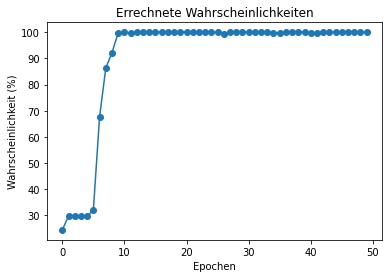

In [ ]:
evolve(GENES, BITS, c, s, m, EPOCHS, 
       selection_type=SelectionType.TOURNAMENT,             # zur Auswahl von Individueen für Natürliche Selektion (WHEEL oder TOURNAMENT)
       crossover_selection_type=SelectionType.TOURNAMENT,   # zur Auswahl von Individueen für Crossover (WHEEL oder TOURNAMENT)
       crossover_type=CrossoverType.ONEPOINT)               # konkrete Crossover-Logik (momentan nur ONEPOINT lt Folien, ist erweiterbar)
